In [1]:
!git clone https://github.com/elemannoni/SNR-based-Selective-Model-Merging.git
%cd SNR-based-Selective-Model-Merging

Cloning into 'SNR-based-Selective-Model-Merging'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 140 (delta 67), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 60.64 KiB | 1.35 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/home/simone/jupyter_files/SNR-based-Selective-Model-Merging


## Importazione librerie utili

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import time
import tracemalloc
from scipy.optimize import linear_sum_assignment
from copy import deepcopy
from sklearn.metrics import f1_score
import pandas as pd

## Preparazione Pytorch e modello

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilizza il dispositivo: {device}")

Utilizza il dispositivo: cuda


In [4]:
from src.model import CNN_snr

## Dataset e dataloader

In [5]:
from src.dataset import create_dataloader_CIFAR10
A_indices = [0, 1, 8, 9]
B_indices = [2, 3, 4, 5, 6, 7]
loader_A, loader_B, test_loader_A, test_loader_B, loader_full_train, loader_full_test = create_dataloader_CIFAR10(A_indices, B_indices, batch_size = 1024)

100%|██████████| 170M/170M [00:48<00:00, 3.51MB/s] 


Creato dataset di training A con 20000 campioni.
Creato dataset di training B con 30000 campioni.
Creato dataset di test A con 4000 campioni.
Creato dataset di test B con 6000 campioni.


## Train

In [6]:
from src.train_and_evaluation import train_model, evaluate_model
from src.utils import transfer_body_weights


print("--- Addestramento Modello Base (Baseline) ---")
model = CNN_snr(output_size=10)
model.to(device)
train_model(model, loader_full_train, loader_full_test, device = device, epochs=5, lr=0.005)

print("--- Addestramento Modello A (Esperto) ---")
model_A = CNN_snr(output_size=len(A_indices))
transfer_body_weights(model, model_A)
model_A.to(device)
train_model(model_A, loader_A, test_loader_A, device = device, epochs=5)

print("\n--- Addestramento Modello B (Esperto) ---")
model_B = CNN_snr(output_size=len(B_indices))
transfer_body_weights(model, model_B)
model_B.to(device)
train_model(model_B, loader_B, test_loader_B, device = device, epochs=5)

--- Addestramento Modello Base (Baseline) ---
Inizio addestramento per 5 epoche...
Epoch 1/5 -> Loss: 1.6732, Accuracy sul Test Set: 40.48%, F1-Score: 37.29%
Epoch 2/5 -> Loss: 1.1167, Accuracy sul Test Set: 60.88%, F1-Score: 58.76%
Epoch 3/5 -> Loss: 0.8658, Accuracy sul Test Set: 66.84%, F1-Score: 65.34%
Epoch 4/5 -> Loss: 0.7174, Accuracy sul Test Set: 72.26%, F1-Score: 71.77%
Epoch 5/5 -> Loss: 0.6046, Accuracy sul Test Set: 74.91%, F1-Score: 74.76%
Addestramento completato.
--- Addestramento Modello A (Esperto) ---
Pesi del corpo trasferiti da backbone a esperto (output_size=4).
Inizio addestramento per 5 epoche...
Epoch 1/5 -> Loss: 0.8411, Accuracy sul Test Set: 88.58%, F1-Score: 88.47%
Epoch 2/5 -> Loss: 0.2747, Accuracy sul Test Set: 89.55%, F1-Score: 89.57%
Epoch 3/5 -> Loss: 0.1372, Accuracy sul Test Set: 91.92%, F1-Score: 91.93%
Epoch 4/5 -> Loss: 0.0812, Accuracy sul Test Set: 92.20%, F1-Score: 92.20%
Epoch 5/5 -> Loss: 0.0532, Accuracy sul Test Set: 92.45%, F1-Score: 92.4

## Allineamento

Per fare merging tra due modelli non si può semplicemente mediare i loro pesi. Due modelli differenti infatti, anche se svolgono lo stesso compito, potrebbero aver imparato le stesse feature in un ordine completamente diverso. Questo disallineamento è dato dalla **simmetria delle permutazioni**: una proprietà delle reti neurali per cui è possibile scambiare l'ordine dei neuroni in un layer (riorninandone poi le connessioni nel layer successivo) senza alterare l'output della rete.


L'algoritmo di **Git-Rebasin** (descritto nel paper https://arxiv.org/abs/2209.04836) risolve questo problema cercando una **permutazione ottimale** che riallinea i neuroni dei due modelli.

In particolare, l'algoritmo implementato:
* **Calcola la Matrice dei Costi:** dato un layer, calcola il costo per associare ogni neurone di $A$ con ogni neurone di $B$ tramite la distanza $L_2$.
* **Trova la Permutazione Ottimale:** Usa l'*Algoritmo Ungherese* (linear_sum_assignment) per minimizzare il costo totale e trovare quindi la matrice di permutazione $P$.
* **Applica la Permutazione:** Applica $W'_i = P * W_i$ e poi $W'_{i+1} = W_{i+1} * P^{-1}$ al layer successivo.

In [7]:
from src.utils import git_rebasin_align
aligned_model_B = git_rebasin_align(model, model_B, device = device)
aligned_model_A = git_rebasin_align(model, model_A, device = device)

Testiamo la consistenza ciclica dell'allineamento. Ci si aspetta una perdita bassa per modelli ben allineati.

In [8]:
from src.utils import cycle_consistency
cycle_consistency(model, model_A, model_B, device = device)

Perdita di Coerenza Ciclica A: 0.0
Perdita di Coerenza Ciclica B: 0.0


Verifichiamo che l'allineamento abbia apportato modifiche. Infatti avendo due modelli specializzati inizializzati dallo stesso modello, potrebbero essere giá allineati in partenza (l'algoritmo di allineamento non effettua modifiche in questo caso)

In [9]:
from src.utils import check_models_identical

is_alignment_B = check_models_identical(model_B, aligned_model_B)
print(f"L'allineamento ha lasciato model_B invariato? -> {is_alignment_B}")

is_alignment_A = check_models_identical(model_A, aligned_model_A)
print(f"L'allineamento ha lasciato model_A invariato? -> {is_alignment_A}")

is_alignment_noop = is_alignment_A and is_alignment_B

L'allineamento ha lasciato model_B invariato? -> True
L'allineamento ha lasciato model_A invariato? -> True


## SNR e merge

Si calcola il Signal-to-Noise Ratio (SNR) per ogni layer di entrambi i modelli allineati secondo quanto descritto nel paper [Spectrum: Targeted Training on Signal to Noise Ratio](https://arxiv.org/abs/2406.06623). I layer con SNR più alto sono considerati più "importanti" e saranno quelli selezionati per il merging.

In [10]:
from src.SNR import calculate_snr


snr_scores = {'model_A': [], 'model_B': [], 'model': []}
for layer in model_A.layers:
  snr_scores['model_A'].append(calculate_snr(layer.weight))

for layer in aligned_model_B.layers:
  snr_scores['model_B'].append(calculate_snr(layer.weight))

for layer in model.layers:
    snr_scores['model'].append(calculate_snr(layer.weight))

## Merging

Si implementa una funzione che permette di fare *merging* dei modelli considerando solo i layer più "importanti" classificandoli secondo il loro SNR. I layer restanti vengono copiati da un modello di riferimento. <br>
Il merging avviene sfruttando 3 diverse tecniche.<br>
- **LERP**: Consiste nel calcolare una media pesata dei parametri (pesi e bias) dei due modelli.
- **SLERP**: Questa tecnica interpola i parametri lungo un arco di cerchio su un'ipersfera.
- **TIES**: Tecnica che mira a risolvere le "interferenze" tra i parametri appresi dai due modelli fondendo solo quelli che hanno appreso nella stessa direzione rispetto a un modello di partenza. Paper di riferimento: [TIES-Merging: Resolving Interference When Merging Models](https://arxiv.org/abs/2306.01708)

In [11]:
from src.merge import merge_models_top_p


indices_merged_10, merged_model_10 = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p=0.10
)

indices_merged_15, merged_model_15 = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p=0.15
)

indices_merged_avg_snr, merged_model_avg_snr = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p=0.15, snr_avg=True
)

indices_merged_slerp_10, merged_model_slerp_10 = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p=0.10, merge_method='slerp'
)

indices_merged_slerp_15, merged_model_slerp_15 = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p=0.15, merge_method='slerp'
)

indices_merged_ties_10, merged_model_ties_10 = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p=0.10, merge_method='ties'
)

indices_merged_ties_15, merged_model_ties_15 = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p=0.15, merge_method='ties'
)

all_indices_lerp , merged_model_lerp = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p = 1
)

all_indices_slerp , merged_model_slerp = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p = 1, merge_method='slerp'
)

all_indices_ties , merged_model_ties = merge_models_top_p(
    aligned_model_A, aligned_model_B, deepcopy(model),
    snr_scores['model_A'], snr_scores['model_B'], snr_scores['model'], top_p = 1, merge_method='ties'
)

## Consistenza post-merging


Si esegue un'analisi di consistenza basata sull'aritmetica dei task vector descritta nel paper [Editing Models with Task Arithmetic](https://arxiv.org/abs/2212.04089). Si calcola la "direzione" dei modelli rispetto a un modello di riferimento per capire se dopo il merging il nuovo modello si trova dove ci si attendeva.<br>
- Valori positivi e intorno ad 1 indicano una forte somiglianza tra il valore atteso e quello ottenuto.
- Valori intorno a 0 indicano una scarsa vicinanza al valore atteso e quindi il modello dopo il merging non ha acquisito conoscenza di task aggiuntive.
- Valori vicino a -1 indicano che il merging é stato distruttivo rispetto ad alcune task.<br>
Non avendo eseguito il merging su tutti i layer ci si aspettano valori scarsi o negativi se il test é eseguito sui modelli completi. Analizzando solo il layer fusi ci si aspetta di vedere risultati coerenti con la accuratezza del modello ad eseguire determinate task.

In [12]:
from src.utils import calculate_delta, perform_consistency_analysis, print_summary

analysis_targets = [
    {"name": "LERP 10%", "model": merged_model_10, "indices": indices_merged_10},
    {"name": "LERP 15%", "model": merged_model_15, "indices": indices_merged_15},
    {"name": "LERP 15% (SNR Avg)", "model": merged_model_avg_snr, "indices": indices_merged_avg_snr},
    {"name": "SLERP 10%", "model": merged_model_slerp_10, "indices": indices_merged_slerp_10},
    {"name": "SLERP 15%", "model": merged_model_slerp_15, "indices": indices_merged_slerp_15},
    {"name": "TIES 10%", "model": merged_model_ties_10, "indices": indices_merged_ties_10},
    {"name": "TIES 15%", "model": merged_model_ties_15, "indices": indices_merged_ties_15},
    {"name": "Full LERP", "model": merged_model_lerp, "indices": all_indices_lerp},
    {"name": "Full SLERP", "model": merged_model_slerp, "indices": all_indices_slerp},
    {"name": "Full TIES", "model": merged_model_ties, "indices": all_indices_ties},
]

#Preparazione dei Delta di Base
base_model_ref = model
expert_A = aligned_model_A
expert_B = aligned_model_B
LAYER_NAME_TO_IGNORE = 'output'

delta_A_full = calculate_delta(expert_A, base_model_ref, layer_to_ignore=LAYER_NAME_TO_IGNORE)
delta_B_full = calculate_delta(expert_B, base_model_ref, layer_to_ignore=LAYER_NAME_TO_IGNORE)


total_consistency_results = {}
for target in analysis_targets:
    name = target["name"]
    merged_model = target["model"]

    delta_merged_full = calculate_delta(merged_model, base_model_ref, layer_to_ignore=LAYER_NAME_TO_IGNORE)

    consistency_A, consistency_B, avg_consistency = perform_consistency_analysis(
        delta_A_full, delta_B_full, delta_merged_full
    )

    total_consistency_results[name] = {
        'consistency_A': consistency_A, 'consistency_B': consistency_B, 'avg_consistency': avg_consistency
    }


selective_consistency_results = {}
all_param_keys = delta_A_full.keys()

for target in analysis_targets:
    name = target["name"]
    merged_model = target["model"]
    merged_indices = target["indices"]

    #Nomi dei parametri corrispondenti agli indici
    keys_to_analyze = {k for k in all_param_keys if any(k.startswith(f"layers.{idx}.") for idx in merged_indices)}

    if not keys_to_analyze:
        continue

    #Filtro dei delta
    delta_A_filtered = {k: v for k, v in delta_A_full.items() if k in keys_to_analyze}
    delta_B_filtered = {k: v for k, v in delta_B_full.items() if k in keys_to_analyze}
    delta_merged_full = calculate_delta(merged_model, base_model_ref, layer_to_ignore=LAYER_NAME_TO_IGNORE)
    delta_merged_filtered = {k: v for k, v in delta_merged_full.items() if k in keys_to_analyze}

    consistency_A, consistency_B, avg_consistency = perform_consistency_analysis(
        delta_A_filtered, delta_B_filtered, delta_merged_filtered
    )

    selective_consistency_results[name] = {
        'consistency_A': consistency_A, 'consistency_B': consistency_B, 'avg_consistency': avg_consistency
    }

print_summary("CONSISTENZA: TUTTI I LAYER", total_consistency_results)
print_summary("CONSISTENZA: SOLO LAYER FUSI", selective_consistency_results)


CONSISTENZA: TUTTI I LAYER
                   consistency_A consistency_B avg_consistency
Full LERP                 0.9113       -0.7993          0.0560
Full SLERP                0.9113       -0.7993          0.0560
Full TIES                 0.9113       -0.7994          0.0560
LERP 15%                  0.9113       -0.7994          0.0560
SLERP 15%                 0.9113       -0.7994          0.0560
LERP 15% (SNR Avg)        0.9113       -0.7994          0.0560
LERP 10%                  0.9113       -0.7994          0.0560
SLERP 10%                 0.9113       -0.7994          0.0560
TIES 10%                  0.9113       -0.7994          0.0560
TIES 15%                  0.9113       -0.7994          0.0560

CONSISTENZA: SOLO LAYER FUSI
                   consistency_A consistency_B avg_consistency
LERP 15%                  1.0000        1.0000          1.0000
LERP 15% (SNR Avg)        1.0000        1.0000          1.0000
LERP 10%                  1.0000        1.0000          1.00

## Fine-tuning e risultati

É necessario verificare come si comportano i nuovi modelli. Per seguire quanto descritto nel paper di riferimento, si "congelano" alcuni layer per addestrare solo quelli interessati dal merging (e necessariamente anche l'output layer)

In [13]:
from src.utils import freeze_layers_selectively

Si calcolano accuratezza e F1-Score prima e dopo il fine-tuning del modello baseline, di un modello con merging non allineato (se l'allineamento ha senso) e di tutti i modelli fusi. Questi ultimi vengono addestrati congelando tutti i layer eccetto quello di output, congelando tutti i layer non selezionati in base all'SNR e senza congelamenti. Un'accuratezza o F1-score inferiore al modello baseline prima del fine-tuning indica un modello poco efficace. Ci si aspetta di migliorare le metriche di valutazione con i modelli addestrati senza congelamenti. Si auspica in metriche comparabili o superiori al modello baseline fine-tuned per quanto riguarda i modelli addestrati con layer congelati, a fronte di picchi di memoria e tempi di addestramento piú bassi.

In [14]:
from src.test import finetuning_experiments
merged_models_to_evaluate = {
      "Merged Lerp 10%":  {"model": merged_model_10, "indices": indices_merged_10},
      "Merged Lerp 15%":  {"model": merged_model_15,  "indices": indices_merged_15},
      "Merged Avg Snr 15%":  {"model": merged_model_avg_snr,  "indices": indices_merged_avg_snr},
      "Merged Slerp 10%":   {"model": merged_model_slerp_10,  "indices": indices_merged_slerp_10},
      "Merged Slerp 15%":   {"model": merged_model_slerp_15,  "indices": indices_merged_slerp_15},
      "Merged Ties 10%":    {"model": merged_model_ties_10,  "indices": indices_merged_ties_10},
      "Merged Ties 15%":    {"model": merged_model_ties_15,  "indices": indices_merged_ties_15},
      "Full LERP":          {"model": merged_model_lerp,  "indices": all_indices_lerp},
      "Full SLERP":         {"model": merged_model_slerp, "indices": all_indices_slerp},
      "Full TIES":         {"model": merged_model_ties, "indices": all_indices_ties},
  }
results = finetuning_experiments(model, model_A, model_B, merged_models_to_evaluate, loader_full_train, loader_full_test, device, is_alignment_noop)


Test: Fine-Tuning del Modello Base (No-Merge)...
Inizio addestramento per 10 epoche...
Epoch 1/10 -> Loss: 0.4566, Accuracy sul Test Set: 80.55%, F1-Score: 80.58%
Epoch 2/10 -> Loss: 0.4164, Accuracy sul Test Set: 81.09%, F1-Score: 81.07%
Epoch 3/10 -> Loss: 0.3937, Accuracy sul Test Set: 81.23%, F1-Score: 81.21%
Epoch 4/10 -> Loss: 0.3774, Accuracy sul Test Set: 81.56%, F1-Score: 81.56%
Epoch 5/10 -> Loss: 0.3612, Accuracy sul Test Set: 81.57%, F1-Score: 81.54%
Epoch 6/10 -> Loss: 0.3499, Accuracy sul Test Set: 81.78%, F1-Score: 81.76%
Epoch 7/10 -> Loss: 0.3358, Accuracy sul Test Set: 81.86%, F1-Score: 81.84%
Epoch 8/10 -> Loss: 0.3246, Accuracy sul Test Set: 81.72%, F1-Score: 81.69%
Epoch 9/10 -> Loss: 0.3130, Accuracy sul Test Set: 81.86%, F1-Score: 81.85%
Epoch 10/10 -> Loss: 0.3028, Accuracy sul Test Set: 81.96%, F1-Score: 81.94%
Addestramento completato.

Test: Fusione Naive (Senza Allineamento)...
L'allineamento non ha modificato i pesi di model_B quindi testare il modello non

In [15]:
#Intestazione della tabella
header = (
    f"{'Modello (Strategia)':<55} | "
    f"{'Acc. Zero-Shot (%)':<22} | "
    f"{'Acc. Fine-Tuned (%)':<22} | "
    f"{'F1 Fine-Tuned (%)':<22} | "
    f"{'Tempo Add. (s)':<18} | "
    f"{'Picco RAM (GB)':<18}"
)
print(header)
print("-"*150)


for name, res_data in results.items():
    acc_zs = res_data.get('acc_zero_shot')
    acc_ft = res_data.get('acc_finetuned')
    f1_ft = res_data.get('f1_finetuned')
    t = res_data.get('time')
    mem = res_data.get('ram_gb')

    #("N/A" se un dato non è applicabile)
    acc_zs_str = f"{acc_zs:.2f}" if acc_zs is not None else "N/A"
    acc_ft_str = f"{acc_ft:.2f}" if acc_ft is not None else "N/A"
    f1_ft_str = f"{f1_ft:.2f}" if f1_ft is not None else "N/A"
    t_str = f"{t:.2f}" if t is not None else "N/A"
    mem_str = f"{mem:.2f}" if mem is not None else "N/A"

    print(
        f"{name:<55} | "
        f"{acc_zs_str:<22} | "
        f"{acc_ft_str:<22} | "
        f"{f1_ft_str:<22} | "
        f"{t_str:<18} | "
        f"{mem_str:<18}"
    )

Modello (Strategia)                                     | Acc. Zero-Shot (%)     | Acc. Fine-Tuned (%)    | F1 Fine-Tuned (%)      | Tempo Add. (s)     | Picco RAM (GB)    
------------------------------------------------------------------------------------------------------------------------------------------------------
Base Model + Fine-Tune                                  | 74.91                  | 81.96                  | 81.94                  | 104.30             | 13.18             
Merged Lerp 10% (Only Head)                             | 75.15                  | 79.03                  | 79.01                  | 45.26              | 1.38              
Merged Lerp 10% (Selective FT)                          | 75.15                  | 80.95                  | 80.96                  | 86.57              | 12.84             
Merged Lerp 10% (Full FT)                               | 75.15                  | 81.66                  | 81.66                  | 104.33             | 13.

## Plot finali

In [16]:
from src.utils import get_plot_colors, get_group_name, extract_metrics_from_results
baseline_model_name = "Base Model + Fine-Tune"
metrics = extract_metrics_from_results(results, baseline_model_name)

labels_acc, data_acc, baseline_acc, min_baseline_acc = metrics["acc"]
labels_f1, data_f1, baseline_f1, min_baseline_f1 = metrics["f1"]
labels_time, data_time, baseline_time = metrics["time"]
labels_mem, data_mem, baseline_mem = metrics["mem"]

Grafico 1: Accuratezza Fine-Tuned

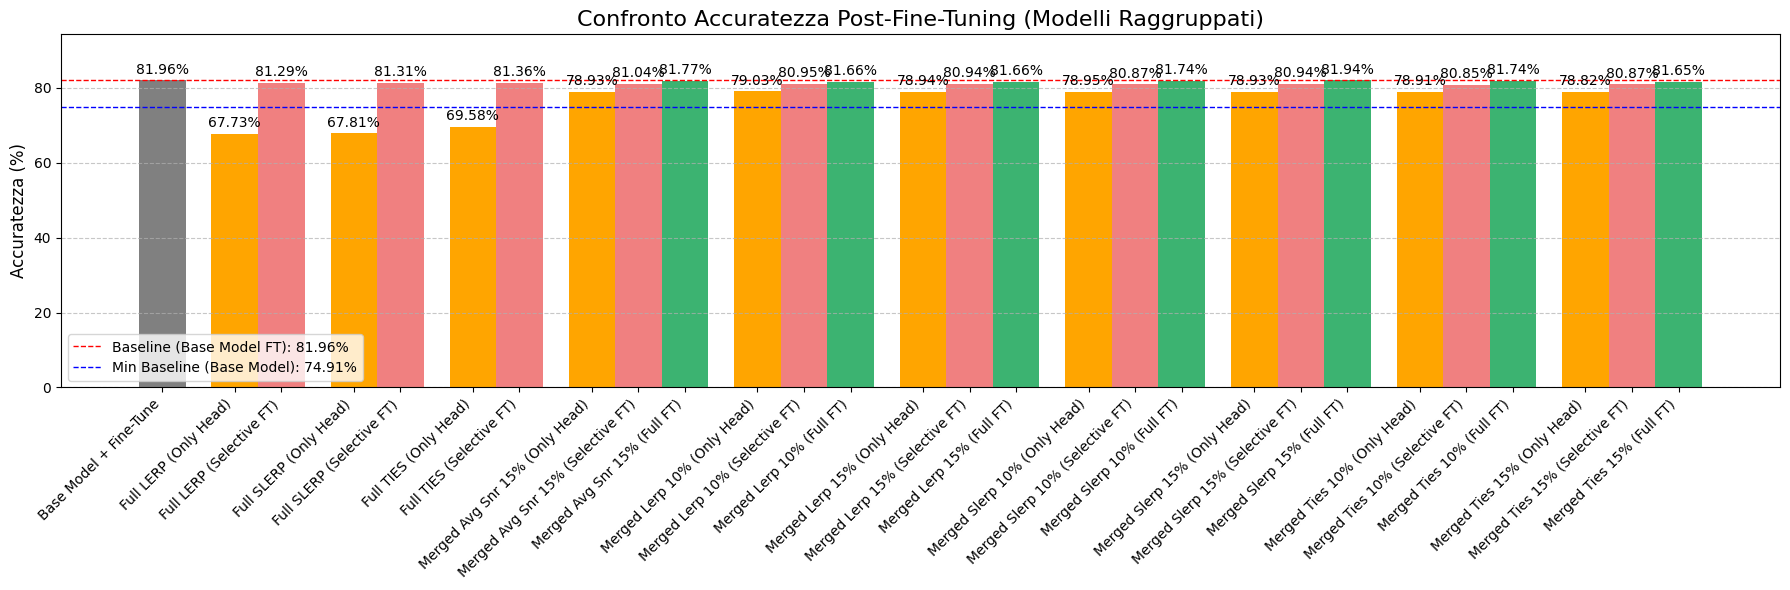

In [17]:
if data_acc:
    plt.figure(figsize=(18, 6))


    zipped_data = sorted(zip(labels_acc, data_acc), key=lambda x: get_group_name(x[0]))
    sorted_labels = [item[0] for item in zipped_data]
    sorted_data = [item[1] for item in zipped_data]

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(sorted_labels):
        if i > 0 and get_group_name(name) != get_group_name(sorted_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width


    colors = get_plot_colors(sorted_labels)
    bars = plt.bar(x_positions, sorted_data, color=colors, width=bar_width)

    if baseline_acc is not None:
        plt.axhline(y=baseline_acc, color='r', linestyle='--', linewidth=1, label=f'Baseline (Base Model FT): {baseline_acc:.2f}%')
        plt.legend()
    if min_baseline_acc is not None and min_baseline_acc != baseline_acc:
        plt.axhline(y=min_baseline_acc, color='blue', linestyle='--', linewidth=1, label=f'Min Baseline (Base Model): {min_baseline_acc:.2f}%')
        plt.legend()
    plt.ylabel('Accuratezza (%)', fontsize=12)
    plt.title('Confronto Accuratezza Post-Fine-Tuning (Modelli Raggruppati)', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(sorted_data) * 1.15)


    plt.xticks(ticks=x_positions, labels=sorted_labels, rotation=45, ha="right")

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        plt.text(x_positions[i], yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Grafico 2: F1-Score Fine-Tuned

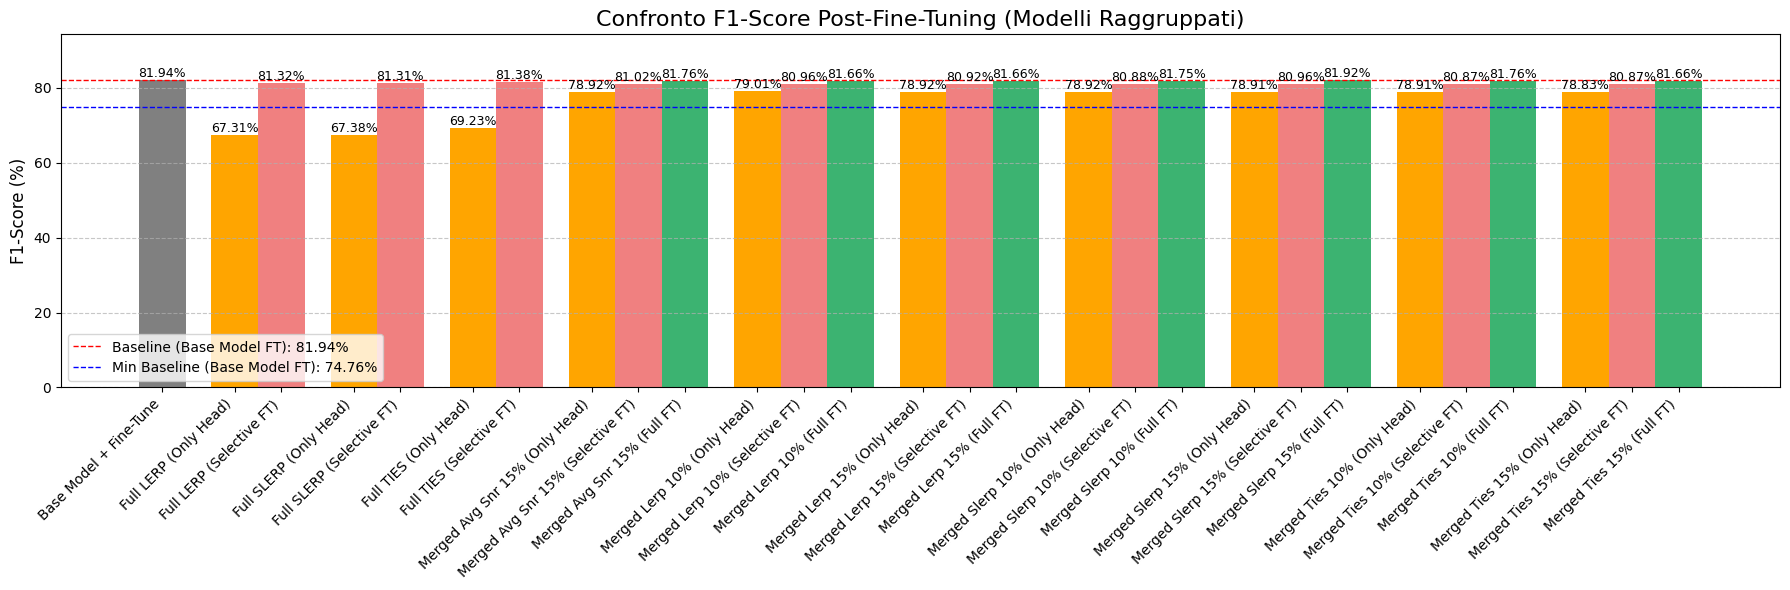

In [18]:
if data_f1:
    plt.figure(figsize=(18, 6))

    zipped_data = sorted(zip(labels_f1, data_f1), key=lambda x: get_group_name(x[0]))
    sorted_labels = [item[0] for item in zipped_data]
    sorted_data = [item[1] for item in zipped_data]

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(sorted_labels):
        if i > 0 and get_group_name(name) != get_group_name(sorted_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width

    colors = get_plot_colors(sorted_labels)
    bars = plt.bar(x_positions, sorted_data, color=colors, width=bar_width)

    if baseline_f1 is not None:
        plt.axhline(y=baseline_f1, color='r', linestyle='--', linewidth=1, label=f'Baseline (Base Model FT): {baseline_f1:.2f}%')
        plt.legend()
    if min_baseline_f1 is not None and min_baseline_f1 != baseline_f1:
        plt.axhline(y=min_baseline_f1, color='blue', linestyle='--', linewidth=1, label=f'Min Baseline (Base Model FT): {min_baseline_f1:.2f}%')
        plt.legend()

    plt.ylabel('F1-Score (%)', fontsize=12)
    plt.title('Confronto F1-Score Post-Fine-Tuning (Modelli Raggruppati)', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(sorted_data) * 1.15)

    plt.xticks(ticks=x_positions, labels=sorted_labels, rotation=45, ha="right")

    for bar in bars:
        yval = bar.get_height()
        center_x = bar.get_x() + bar.get_width() / 2.0  # Calcola il centro della barra
        plt.text(center_x, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

Grafico 3: Tempo di Addestramento

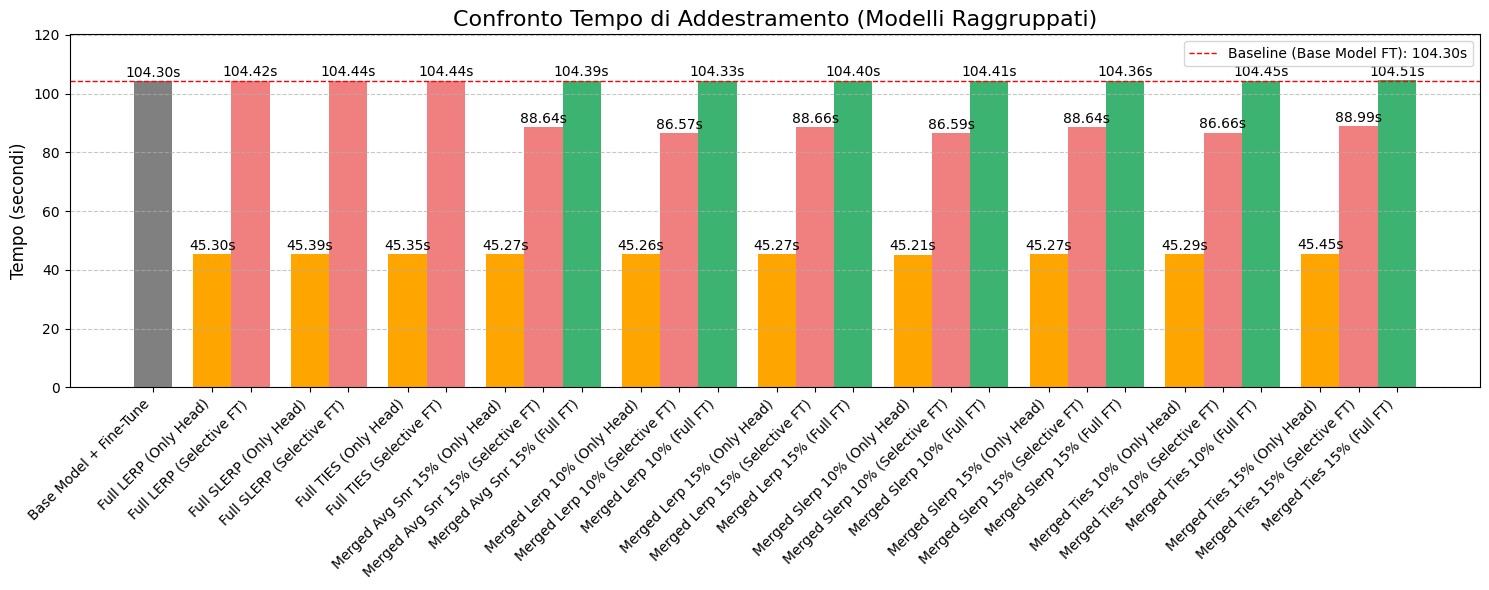

In [19]:
if data_time:
    plt.figure(figsize=(15, 6))

    zipped_data = sorted(zip(labels_time, data_time), key=lambda x: get_group_name(x[0]))
    sorted_labels = [item[0] for item in zipped_data]
    sorted_data = [item[1] for item in zipped_data]

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(sorted_labels):
        if i > 0 and get_group_name(name) != get_group_name(sorted_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width

    colors = get_plot_colors(sorted_labels)
    bars = plt.bar(x_positions, sorted_data, color=colors, width=bar_width)

    if baseline_time is not None:
        plt.axhline(y=baseline_time, color='r', linestyle='--', linewidth=1, label=f'Baseline (Base Model FT): {baseline_time:.2f}s')
        plt.legend()

    plt.ylabel('Tempo (secondi)', fontsize=12)
    plt.title('Confronto Tempo di Addestramento (Modelli Raggruppati)', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(sorted_data) * 1.15)
    plt.xticks(ticks=x_positions, labels=sorted_labels, rotation=45, ha="right")

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        plt.text(x_positions[i], yval + 0.5, f'{yval:.2f}s', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Grafico 4: Picco di Utilizzo Memoria

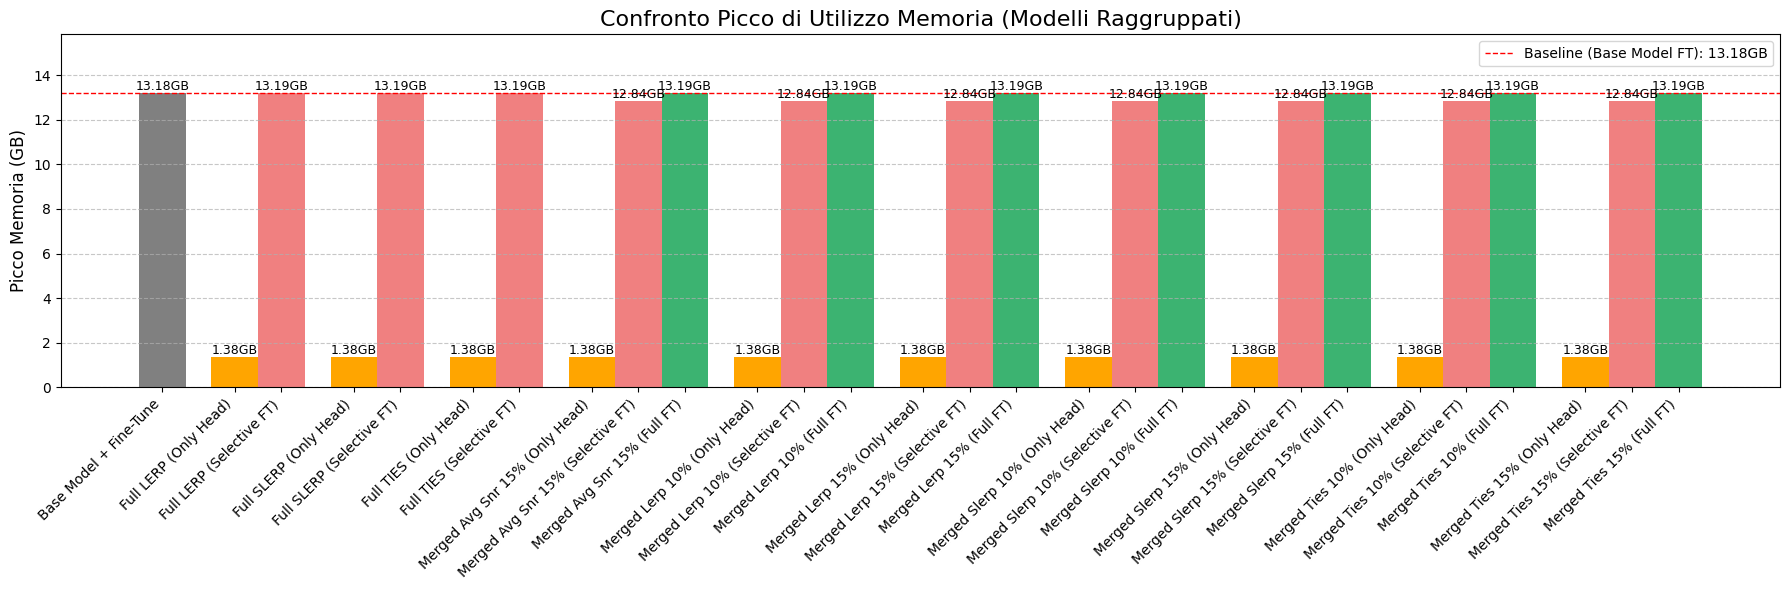

In [20]:
if data_mem:
    plt.figure(figsize=(18, 6))

    zipped_data = sorted(zip(labels_mem, data_mem), key=lambda x: get_group_name(x[0]))
    sorted_labels = [item[0] for item in zipped_data]
    sorted_data = [item[1] for item in zipped_data]

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(sorted_labels):
        if i > 0 and get_group_name(name) != get_group_name(sorted_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width

    colors = get_plot_colors(sorted_labels)
    bars = plt.bar(x_positions, sorted_data, color=colors, width=bar_width)

    if baseline_mem is not None:
        plt.axhline(y=baseline_mem, color='r', linestyle='--', linewidth=1, label=f'Baseline (Base Model FT): {baseline_mem:.2f}GB')
        plt.legend()

    plt.ylabel('Picco Memoria (GB)', fontsize=12)
    plt.title('Confronto Picco di Utilizzo Memoria (Modelli Raggruppati)', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(sorted_data) * 1.20)
    plt.xticks(ticks=x_positions, labels=sorted_labels, rotation=45, ha="right")

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        plt.text(x_positions[i], yval, f'{yval:.2f}GB', ha='center', va='bottom', rotation=0, fontsize=9)

    plt.tight_layout()
    plt.show()

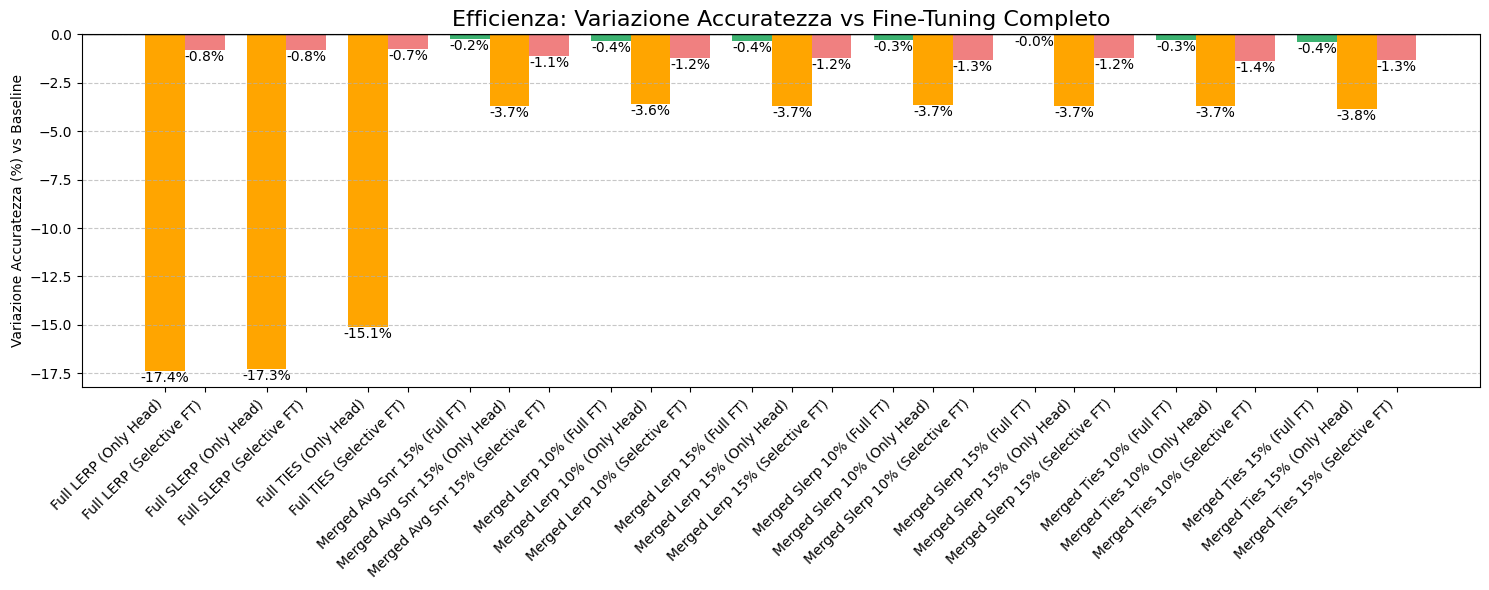

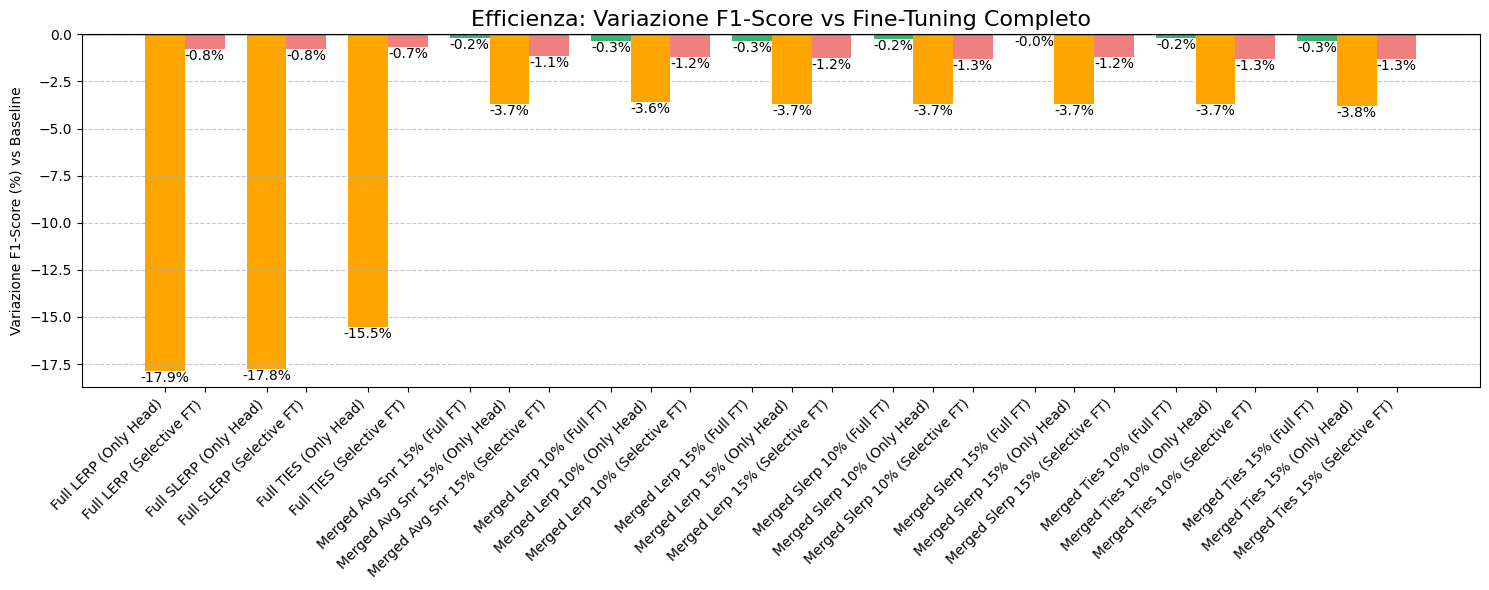

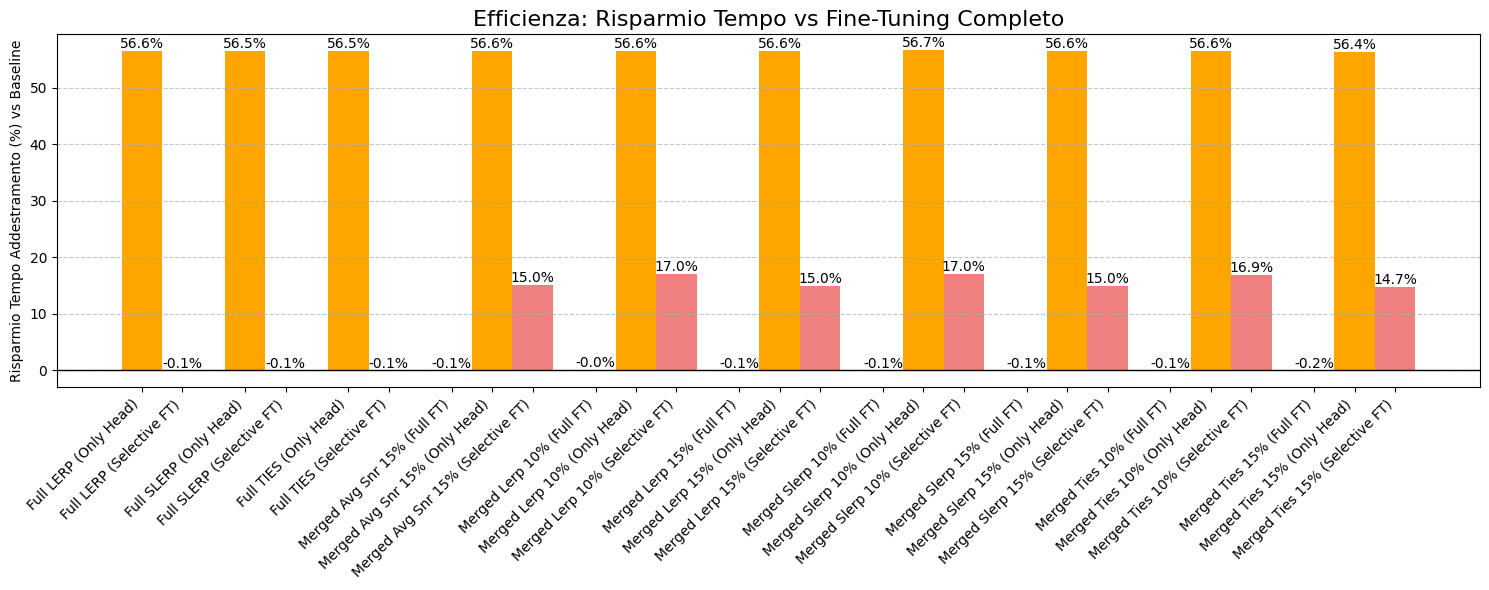

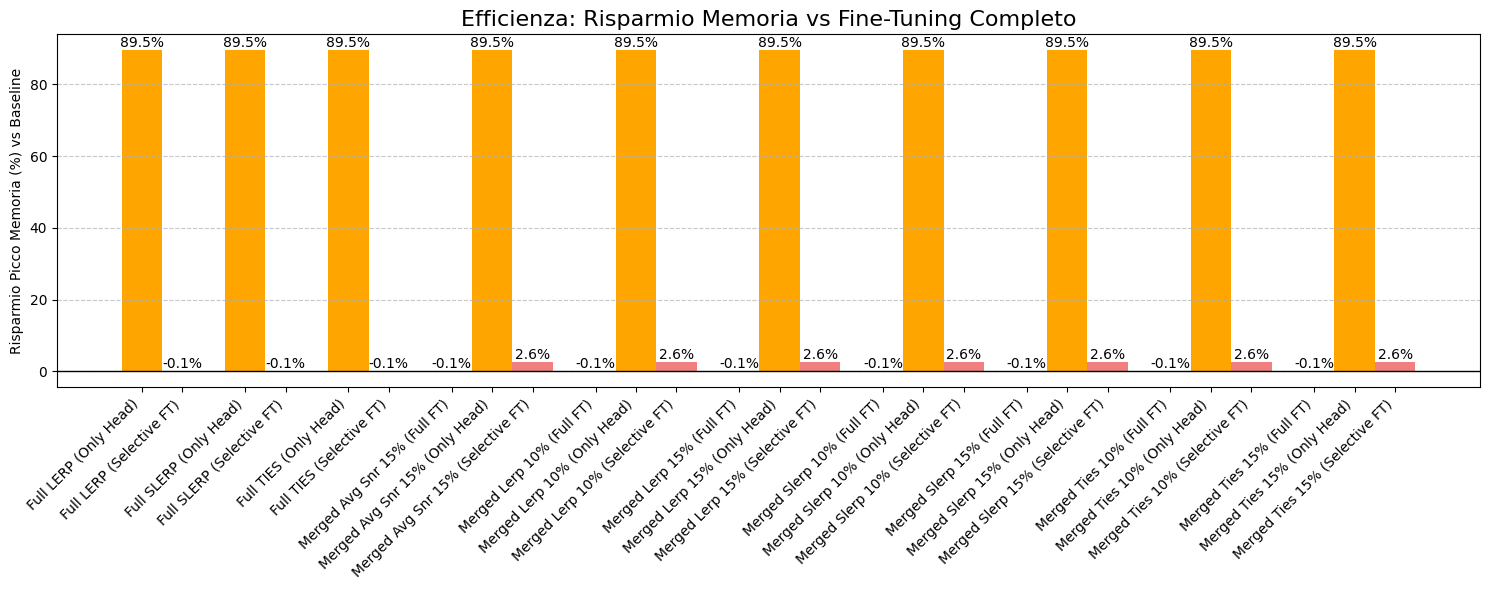

In [21]:
if baseline_acc is not None and baseline_time is not None and baseline_mem is not None:

    efficiency_labels = []
    acc_change_data = []
    f1_change_data = []
    time_gain_data = []
    mem_gain_data = []

    #Preparazione dei dati: dizionario temporaneo per ordinare prima per gruppo o poi per nome
    temp_results = {k: v for k, v in results.items() if k != baseline_model_name}
    sorted_items = sorted(temp_results.items(), key=lambda item: (get_group_name(item[0]), item[0]))

    for name, res in sorted_items:
        efficiency_labels.append(name)

        acc_change = ((res.get('acc_finetuned', baseline_acc) - baseline_acc) / baseline_acc) * 100
        f1_change = ((res.get('f1_finetuned', baseline_f1) - baseline_f1) / baseline_f1) * 100
        acc_change_data.append(acc_change)
        f1_change_data.append(f1_change)

        time_gain = ((baseline_time - res.get('time', baseline_time)) / baseline_time) * 100
        mem_gain = ((baseline_mem - res.get('ram_gb', baseline_mem)) / baseline_mem) * 100
        time_gain_data.append(time_gain)
        mem_gain_data.append(mem_gain)

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(efficiency_labels):
        if i > 0 and get_group_name(name) != get_group_name(efficiency_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width

    colors = get_plot_colors(efficiency_labels)

    #Plot 1: Variazione Accuratezza
    plt.figure(figsize=(15, 6))
    bars = plt.bar(x_positions, acc_change_data, color=colors, width=bar_width)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('Variazione Accuratezza (%) vs Baseline')
    plt.title('Efficienza: Variazione Accuratezza vs Fine-Tuning Completo', fontsize=16)
    plt.xticks(ticks=x_positions, labels=efficiency_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(x_positions[i], height, f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
    plt.tight_layout()
    plt.savefig("efficiency_accuracy_grouped.png")

    #Plot 2: Variazione F1-Score
    plt.figure(figsize=(15, 6))
    bars = plt.bar(x_positions, f1_change_data, color=colors, width=bar_width)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('Variazione F1-Score (%) vs Baseline')
    plt.title('Efficienza: Variazione F1-Score vs Fine-Tuning Completo', fontsize=16)
    plt.xticks(ticks=x_positions, labels=efficiency_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(x_positions[i], height, f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
    plt.tight_layout()
    plt.savefig("efficiency_f1_score_grouped.png")

    #Plot 3: Risparmio Tempo Addestramento
    plt.figure(figsize=(15, 6))
    bars = plt.bar(x_positions, time_gain_data, color=colors, width=bar_width)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('Risparmio Tempo Addestramento (%) vs Baseline')
    plt.title('Efficienza: Risparmio Tempo vs Fine-Tuning Completo', fontsize=16)
    plt.xticks(ticks=x_positions, labels=efficiency_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(x_positions[i], height, f'{height:.1f}%', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig("efficiency_time_grouped.png")

    #Plot 4: Risparmio Picco Memoria
    plt.figure(figsize=(15, 6))
    bars = plt.bar(x_positions, mem_gain_data, color=colors, width=bar_width)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('Risparmio Picco Memoria (%) vs Baseline')
    plt.title('Efficienza: Risparmio Memoria vs Fine-Tuning Completo', fontsize=16)
    plt.xticks(ticks=x_positions, labels=efficiency_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(x_positions[i], height, f'{height:.1f}%', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()